<a href="https://colab.research.google.com/github/alik604/ok-boomer/blob/master/working_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working LSTM example and smaple code

there is one issue, do ctrl+F "TODO" to find it 

In [560]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp '/content/drive/My Drive/CMPT 419 project/Data/tech1-agg.csv' tech1.csv
!cp '/content/drive/My Drive/CMPT 419 project/Data/tech2-agg.csv' tech2.csv


In [562]:
!ls

drive  sample_data  tech1.csv  tech2.csv


# start coding 

In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline


import tensorflow as tf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras import regularizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.constraints import max_norm
from keras.layers import Dense, BatchNormalization
from keras.layers import GRU, LSTM, CuDNNGRU, CuDNNLSTM
from keras.utils import to_categorical
from keras.preprocessing import sequence


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [564]:
df1 = pd.read_csv('tech1.csv')
df2 = pd.read_csv('tech2.csv')

df = pd.concat([df1,df2])
df.tail()

,Unnamed: 0,DATE,SYM_ROOT,SIZE,PRICE
8196,140186193,2019-12-31 06:00:00,MSFT,77,157.50
8197,140186209,2019-12-31 07:00:00,MSFT,100,157.34
8198,140186493,2019-12-31 08:00:00,MSFT,2,157.16
8199,140201236,2019-12-31 09:00:00,MSFT,300,157.25
8200,140309303,2019-12-31 01:00:00,MSFT,200,157.85


In [565]:
df = df.drop(['Unnamed: 0'],axis=1)
df.index = df.DATE
df.tail()

,DATE,SYM_ROOT,SIZE,PRICE
DATE,,,,
2019-12-31 06:00:00,2019-12-31 06:00:00,MSFT,77,157.50
2019-12-31 07:00:00,2019-12-31 07:00:00,MSFT,100,157.34
2019-12-31 08:00:00,2019-12-31 08:00:00,MSFT,2,157.16
2019-12-31 09:00:00,2019-12-31 09:00:00,MSFT,300,157.25
2019-12-31 01:00:00,2019-12-31 01:00:00,MSFT,200,157.85


In [566]:
temp = df.SYM_ROOT.values
temp = set(temp)
print(temp)

{'MSFT', 'AMZN', 'AAPL', 'FNGU', 'GOOG'}


In [567]:
aapl = df[df.SYM_ROOT == 'AAPL']
aapl.drop(['SYM_ROOT','SIZE'],axis=1,inplace=True)

aapl.tail(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,DATE,PRICE
DATE,,
2019-12-31 06:00:00,2019-12-31 06:00:00,291.00
2019-12-31 07:00:00,2019-12-31 07:00:00,290.61
2019-12-31 08:00:00,2019-12-31 08:00:00,290.30
2019-12-31 09:00:00,2019-12-31 09:00:00,292.16
2019-12-31 01:00:00,2019-12-31 01:00:00,293.70


In [0]:
y = aapl.PRICE.values
x = np.arange(len(y))

In [672]:
y[0]

169.18

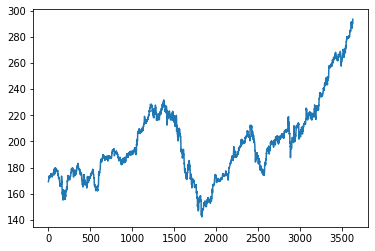

In [673]:
plt.plot(range(len(y)),y)

In [674]:
print('Are X and Y the same size?: ', len(y) == len(x))

Are X and Y the same size?:  True


In [0]:
# scaler = MinMaxScaler(feature_range = (0, 1))
# x = x.reshape(1,-1)
# y = y.reshape(1,-1)
# scaler = scaler.fit(x)
# x = scaler.transform(x)


In [0]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42, shuffle=False )


In [707]:
t = pd.DataFrame(aapl.PRICE.values)
scaler = MinMaxScaler(feature_range = (0, 1))
tt = scaler.fit_transform(t)
tt

array([[0.17814006],
       [0.18018613],
       [0.18137417],
       ...,
       [0.97755924],
       [0.98983565],
       [1.        ]])

In [0]:
X_train = []
y_train = []
maxlen = 60

for i in range(maxlen, 3635):
    X_train.append(tt[i-maxlen:i, 0])
    y_train.append(tt[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [711]:
X_train.shape

(3575, 60, 1)

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=False )

In [713]:
model = Sequential()
model.add(CuDNNGRU(150, input_shape=(maxlen, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mean_squared_error'])

model.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, 150)               68850     
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 151       
Total params: 69,001
Trainable params: 69,001
Non-trainable params: 0
_________________________________________________________________


In [714]:
model.fit(X_train, y_train, epochs = 50, batch_size = 16, validation_split=0.25)

Train on 2681 samples, validate on 894 samples
Epoch 1/50
2681/2681 [==============================] - 3s 1ms/step - loss: 0.0030 - acc: 3.7300e-04 - mean_squared_error: 0.0030 - val_loss: 1.5275e-04 - val_acc: 0.0011 - val_mean_squared_error: 1.5275e-04
Epoch 2/50
2681/2681 [==============================] - 1s 418us/step - loss: 1.2562e-04 - acc: 3.7300e-04 - mean_squared_error: 1.2562e-04 - val_loss: 1.2427e-04 - val_acc: 0.0011 - val_mean_squared_error: 1.2427e-04
Epoch 3/50
2681/2681 [==============================] - 1s 407us/step - loss: 1.1418e-04 - acc: 3.7300e-04 - mean_squared_error: 1.1418e-04 - val_loss: 1.1747e-04 - val_acc: 0.0011 - val_mean_squared_error: 1.1747e-04
Epoch 4/50
2681/2681 [==============================] - 1s 461us/step - loss: 1.1157e-04 - acc: 3.7300e-04 - mean_squared_error: 1.1157e-04 - val_loss: 1.3979e-04 - val_acc: 0.0011 - val_mean_squared_error: 1.3979e-04
Epoch 5/50
2681/2681 [==============================] - 1s 414us/step - loss: 1.1799e-04 - 

<Figure size 1296x432 with 0 Axes>

Text(0, 0.5, 'price')

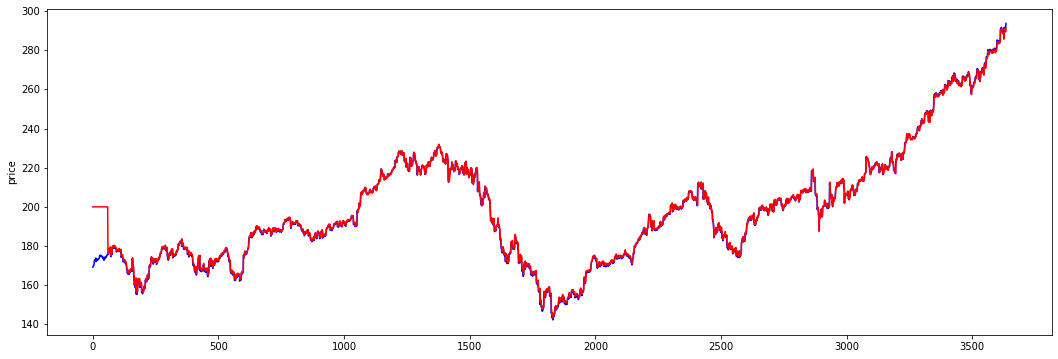

In [715]:
results = model.predict(X_train)

resultss = scaler.inverse_transform(results.reshape(-1,1))
resultss = resultss.reshape(1,-1)[0]
output = np.concatenate([np.ones(maxlen)*200,resultss], axis=0)

plt.figure(figsize = (18,6))
plt.plot(range(len(aapl.PRICE.values)),aapl.PRICE.values,color='b', label="y_train")
plt.plot(range(len(output)), output,color='r', label="predict")
plt.ylabel('price')
plt.show()

<Figure size 1296x432 with 0 Axes>

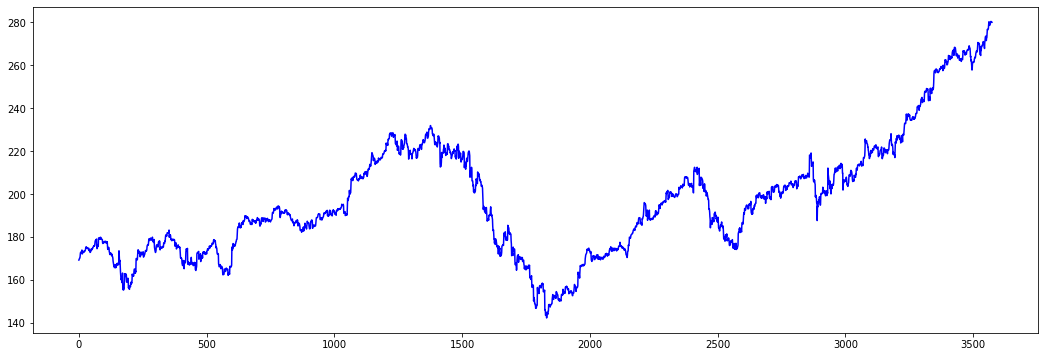

In [716]:
plt.figure(figsize = (18,6))
plt.plot(range(len(aapl.PRICE[:len(results)])), aapl.PRICE[:len(results)],color='b', label="y_train")


In [0]:
# import keras
# from keras import regularizers
# from keras.models import Model, load_model, Sequential
# from keras.layers import *
# from keras.preprocessing import sequence

In [718]:
y = aapl.PRICE.values
y = y.reshape(-1, 1)

x = np.arange(len(y))
x = x.reshape(-1, 1)

scaler_x = MinMaxScaler()
x = scaler_x.fit_transform(x)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)
# X_train_trans = mms.fit_transform(X_train)
# X_test_trans = mms.transform(X_test)

maxlen = 150#100#240

# seqTrain=sequence.pad_sequences(sequences = x, maxlen=maxlen, padding='post', dtype='float32', truncating='post')

X_train = []
y_train = []
for i in range(maxlen, 3635):
    X_train.append(tt[i-maxlen:i, 0])
    y_train.append(tt[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

seqTrain = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

seqTrain.shape

(3485, 150, 1)

In [719]:
seqTrain = seqTrain.reshape((seqTrain.shape[0], maxlen,1))
seqTrain.shape

(3485, 150, 1)

In [0]:
RMSprop_low_LR = keras.optimizers.RMSprop(lr=0.0001)

model = Sequential()
model.add(CuDNNLSTM(160, return_sequences=True))
model.add(CuDNNLSTM(160, return_sequences=False))

# model.add(GRU(150, input_shape=(seqTrain.shape[0],maxlen)))
model.add(Dense(160, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

model.compile(optimizer = RMSprop_low_LR, loss='mean_squared_error', metrics =['mean_squared_error'])



In [606]:
c = model.fit(seqTrain, y_train, batch_size=64, epochs=30, validation_split=0.15)# .history
# for manual padding 

# c = model.fit(seqTrain, y, batch_size=64, epochs=30, validation_split=0.15)# .history

Train on 2962 samples, validate on 523 samples
Epoch 1/30
2962/2962 [==============================] - 3s 1ms/step - loss: 0.0249 - acc: 3.3761e-04 - val_loss: 0.0075 - val_acc: 0.0019
Epoch 2/30
2962/2962 [==============================] - 1s 431us/step - loss: 0.0013 - acc: 3.3761e-04 - val_loss: 8.1146e-04 - val_acc: 0.0019
Epoch 3/30
2962/2962 [==============================] - 1s 428us/step - loss: 0.0011 - acc: 3.3761e-04 - val_loss: 0.0023 - val_acc: 0.0019
Epoch 4/30
2962/2962 [==============================] - 1s 429us/step - loss: 0.0011 - acc: 3.3761e-04 - val_loss: 5.2954e-04 - val_acc: 0.0019
Epoch 5/30
2962/2962 [==============================] - 1s 432us/step - loss: 0.0010 - acc: 3.3761e-04 - val_loss: 6.7479e-04 - val_acc: 0.0019
Epoch 6/30
2962/2962 [==============================] - 1s 432us/step - loss: 8.2563e-04 - acc: 3.3761e-04 - val_loss: 0.0015 - val_acc: 0.0019
Epoch 7/30
2962/2962 [==============================] - 1s 429us/step - loss: 8.3121e-04 - acc: 3.3

<Figure size 1296x432 with 0 Axes>

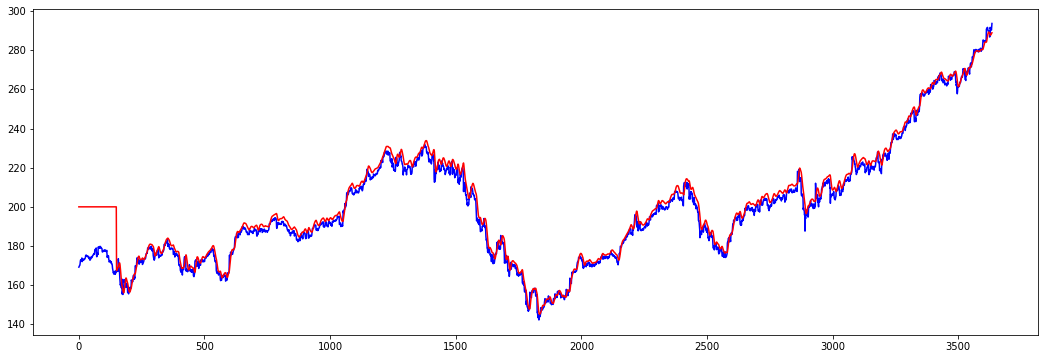

In [669]:
results = model.predict(seqTrain)

resultss = scaler.inverse_transform(results.reshape(-1,1))
resultss = resultss.reshape(1,-1)[0]
output = np.concatenate([np.ones(maxlen)*200,resultss], axis=0)

plt.figure(figsize = (18,6))
plt.plot(range(len(aapl.PRICE.values)),aapl.PRICE.values,color='b', label="y_train")
plt.plot(range(len(output)), output,color='r', label="predict")

# plt.ylabel('price')
plt.show()

<Figure size 1296x432 with 0 Axes>

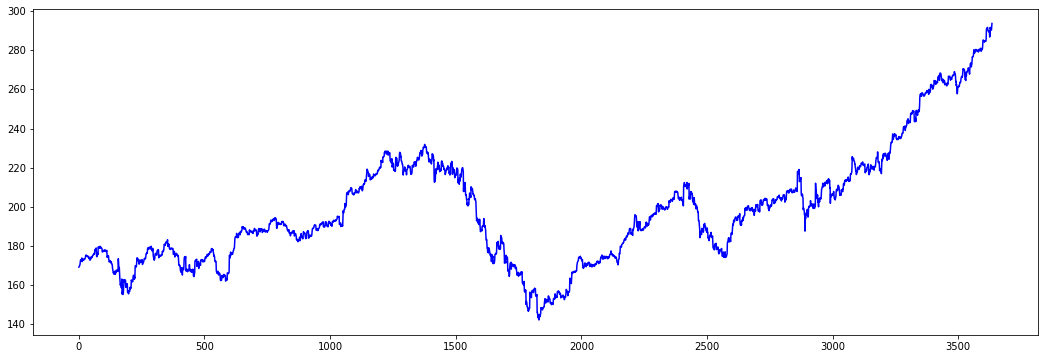

In [623]:
plt.figure(figsize = (18,6))
plt.plot(range(len(aapl.PRICE)), aapl.PRICE,color='b', label="y_train")


# benchmarking hyper-prams

In [720]:
RMSprop_low_LR = keras.optimizers.RMSprop(lr=0.0001)

model = Sequential()
model.add(CuDNNLSTM(160, return_sequences=True))
model.add(CuDNNLSTM(160, return_sequences=False))
model.add(Dense(160, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

model.compile(optimizer = RMSprop_low_LR, loss='mean_squared_error', metrics =['mean_squared_error'])
c = model.fit(seqTrain, y_train, batch_size=64, epochs=30, validation_split=0.15)# .history

Train on 2962 samples, validate on 523 samples
Epoch 1/30
2962/2962 [==============================] - 4s 1ms/step - loss: 0.0222 - acc: 3.3761e-04 - val_loss: 0.0036 - val_acc: 0.0019
Epoch 2/30
2962/2962 [==============================] - 1s 435us/step - loss: 0.0012 - acc: 3.3761e-04 - val_loss: 0.0011 - val_acc: 0.0019
Epoch 3/30
2962/2962 [==============================] - 1s 428us/step - loss: 9.7286e-04 - acc: 3.3761e-04 - val_loss: 4.5275e-04 - val_acc: 0.0019
Epoch 4/30
2962/2962 [==============================] - 1s 430us/step - loss: 8.7404e-04 - acc: 3.3761e-04 - val_loss: 0.0119 - val_acc: 0.0019
Epoch 5/30
2962/2962 [==============================] - 1s 426us/step - loss: 8.4635e-04 - acc: 3.3761e-04 - val_loss: 0.0025 - val_acc: 0.0019
Epoch 6/30
2962/2962 [==============================] - 1s 426us/step - loss: 7.6177e-04 - acc: 3.3761e-04 - val_loss: 3.1464e-04 - val_acc: 0.0019
Epoch 7/30
2962/2962 [==============================] - 1s 427us/step - loss: 6.7593e-04 - 

In [723]:
RMSprop_low_LR = keras.optimizers.RMSprop(lr=0.0001)

model = Sequential()
model.add(CuDNNLSTM(160, return_sequences=True))
model.add(CuDNNLSTM(160, return_sequences=False))

# model.add(GRU(150, input_shape=(seqTrain.shape[0],maxlen)))
model.add(Dense(160, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss='mean_absolute_error', metrics =['mean_squared_error'])
c = model.fit(seqTrain, y_train, batch_size=64, epochs=30, validation_split=0.15)# .history

Train on 2962 samples, validate on 523 samples
Epoch 1/30
2962/2962 [==============================] - 5s 2ms/step - loss: 0.0705 - acc: 3.3761e-04 - val_loss: 0.0276 - val_acc: 0.0019
Epoch 2/30
2962/2962 [==============================] - 1s 452us/step - loss: 0.0200 - acc: 3.3761e-04 - val_loss: 0.0136 - val_acc: 0.0019
Epoch 3/30
2962/2962 [==============================] - 1s 451us/step - loss: 0.0138 - acc: 3.3761e-04 - val_loss: 0.0267 - val_acc: 0.0019
Epoch 4/30
2962/2962 [==============================] - 1s 451us/step - loss: 0.0147 - acc: 3.3761e-04 - val_loss: 0.0221 - val_acc: 0.0019
Epoch 5/30
2962/2962 [==============================] - 1s 458us/step - loss: 0.0138 - acc: 3.3761e-04 - val_loss: 0.0144 - val_acc: 0.0019
Epoch 6/30
2962/2962 [==============================] - 1s 447us/step - loss: 0.0122 - acc: 3.3761e-04 - val_loss: 0.0289 - val_acc: 0.0019
Epoch 7/30
2962/2962 [==============================] - 1s 448us/step - loss: 0.0115 - acc: 3.3761e-04 - val_loss: 